# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
#sc.install_pypi_package("seaborn==0.11.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1637701356139_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [2]:
import matplotlib.pyplot as plt
%matplot inline
%matplot plt
import pyspark.sql.functions as f
from pyspark.sql.functions import avg
from pyspark.sql.functions import lit
from pyspark.sql.functions import collect_set
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, mean
from pyspark.sql.functions import trim
import pandas as pd
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
business = spark.read.json('s3://sta9760f2021-yelp-datasets/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [6]:
print(f'Total Columns: {len(business.dtypes)}')
print(f'Total Rows: {business.count():,}')
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 160,585
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

Display the DataFrame schema below.

In [7]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [8]:
cols = ['business_id', 'name', 'city', 'state' , 'categories']
business.select(cols).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+--------------------+
|         business_id|                name|       city|state|          categories|
+--------------------+--------------------+-----------+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [9]:
two_cols = ['business_id', 'categories']
business.select(two_cols).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|6iYb2HFDywm3zjuRg...|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|Gyms, Active Life...|
+--------------------+--------------------+
only showing top 5 rows

In [11]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
category_explode = business.select(business.business_id, explode(split(business.categories, ', ')))
category_explode = category_explode.withColumnRenamed('col', 'category')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [12]:
category_explode.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [13]:
from pyspark.sql.functions import countDistinct
business_cat = category_explode.select(countDistinct('category'))
business_cat.show(truncate = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|count(DISTINCT category)|
+------------------------+
|1330                    |
+------------------------+

In [14]:

category_explode.createOrReplaceTempView('business_category')

count_distinct = spark.sql(
'''
SELECT COUNT(DISTINCT category) as count_distinct_category FROM business_category

'''
)
count_distinct.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+
|count_distinct_category|
+-----------------------+
|                   1330|
+-----------------------+

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [15]:

category_explode.createOrReplaceTempView('business_category')

category_count = spark.sql(
'''
SELECT category, COUNT(category) as count_category FROM business_category 
GROUP BY category
'''
)
category_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+
|            category|count_category|
+--------------------+--------------+
|      Dermatologists|           351|
|      Paddleboarding|            67|
|        Aerial Tours|             8|
|         Hobby Shops|           610|
|          Bubble Tea|           779|
|             Embassy|             9|
|             Tanning|           701|
|            Handyman|           507|
|      Aerial Fitness|            13|
|             Falafel|           141|
|        Summer Camps|           308|
|       Outlet Stores|           184|
|     Clothing Rental|            37|
|            Yakiniku|             1|
|      Sporting Goods|          1864|
|     Cooking Schools|           114|
|  College Counseling|            20|
|  Lactation Services|            47|
|Ski & Snowboard S...|            55|
|             Museums|           336|
+--------------------+--------------+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [16]:
top20 = spark.sql(
'''
SELECT category, COUNT(category) as count_category FROM business_category 
GROUP BY category
ORDER BY count_category DESC
LIMIT 20
'''
)
top20.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+
|            category|count_category|
+--------------------+--------------+
|         Restaurants|         50763|
|                Food|         29469|
|            Shopping|         26205|
|       Beauty & Spas|         16574|
|       Home Services|         16465|
|    Health & Medical|         15102|
|      Local Services|         12192|
|           Nightlife|         11990|
|                Bars|         10741|
|          Automotive|         10119|
|Event Planning & ...|          9644|
|         Active Life|          9231|
|        Coffee & Tea|          7725|
|          Sandwiches|          7272|
|             Fashion|          6599|
|American (Traditi...|          6541|
|         Hair Salons|          5900|
|               Pizza|          5756|
|     Hotels & Travel|          5703|
|  Breakfast & Brunch|          5505|
+--------------------+--------------+

In [17]:
business_pan = top20.toPandas()
business_pan.sort_values('count_category', ascending = True).plot.barh(y = "count_category", x = 'category',
                                                                     title = 'Top Categories by Business',
                                                                      legend = True)
plt.tight_layout()
plt.xlabel('Count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 23.52222222222222, 'Count')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

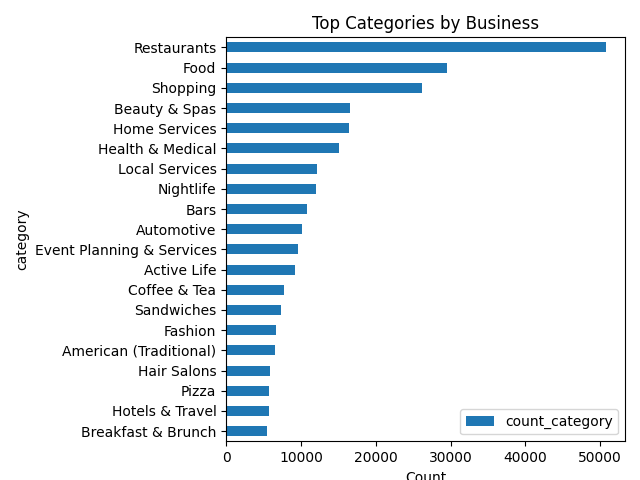

In [18]:
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [19]:
review = spark.read.json('s3://sta9760f2021-yelp-datasets/yelp_academic_dataset_review.json')
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [20]:
col = ['business_id','stars']
review_col = review.select(col)
review_col.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [23]:
review_col.createOrReplaceTempView('review_col')
top_review = spark.sql(
'''
SELECT business_id, AVG(stars) FROM review_col 
GROUP BY business_id
'''
)
top_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|uEUweopM30lHcVxjO...|              3.0|
|wdBrDCbZopowEkIEX...|4.538461538461538|
|L3WCfeVozu5etMhz4...|              4.2|
|bOnsvrz1VkbrZM1jV...|              3.8|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
+--------------------+-----------------+
only showing top 5 rows

In [25]:
cols = ['business_id', 'name', 'city', 'state' , 'categories','stars']
business_df = business.select(cols)
business_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+--------------------+-----+
|         business_id|                name|       city|state|          categories|stars|
+--------------------+--------------------+-----------+-----+--------------------+-----+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|Gastropubs, Food,...|  4.0|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|Salad, Soup, Sand...|  4.0|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|Antiques, Fashion...|  4.5|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|Beauty & Spas, Ha...|  3.0|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|Gyms, Active Life...|  4.0|
+--------------------+--------------------+-----------+-----+--------------------+-----+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [28]:
business_review_df = business_df.join(top_review, business_df.business_id == top_review.business_id)
business_review_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+-----+--------------------+-----+--------------------+------------------+
|         business_id|                name|      city|state|          categories|stars|         business_id|        avg(stars)|
+--------------------+--------------------+----------+-----+--------------------+-----+--------------------+------------------+
|--JuLhLvq3gyjNnXT...|    CheraBella Salon|   Peabody|   MA|Beauty & Spas, Ha...|  5.0|--JuLhLvq3gyjNnXT...|               5.0|
|--_nBudPOb1lNRgKf...|Mezcal Cantina & ...|  Columbus|   OH|Mexican, Gastropu...|  4.0|--_nBudPOb1lNRgKf...|             3.875|
|--kyOk0waSrCDlbSv...|    Red Table Coffee|    Austin|   TX|Coffee & Tea, Res...|  4.0|--kyOk0waSrCDlbSv...|3.8666666666666667|
|--z9usx6Fin8P_f0v...|          WonderWell|    Austin|   TX|Education, Presch...|  5.0|--z9usx6Fin8P_f0v...|               5.0|
|-0qeY1293steyCqYh...|         Avalon Oaks|Wilmington|   MA|Real Estate, Home...|  3.5|-0qeY1293steyCqYh

Let's see a few of these:

In [29]:
cols = ['avg(stars)', 'stars', 'name' , 'city', 'state']
business_review_df.select(cols).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|        avg(stars)|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [32]:
business_review_skew = business_review_df.withColumn('Skew', (business_review_df['avg(stars)'] - 
                                                              business_review_df['stars'] ) / business_review_df['stars'])
cols = ['avg(stars)', 'stars', 'name', 'city', 'state', 'Skew']
business_skew = business_review_skew.select(cols)
business_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+--------------------+
|        avg(stars)|stars|                name|      city|state|                Skew|
+------------------+-----+--------------------+----------+-----+--------------------+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|                 0.0|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|            -0.03125|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|-0.03333333333333...|
|               5.0|  5.0|          WonderWell|    Austin|   TX|                 0.0|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|-0.03571428571428571|
+------------------+-----+--------------------+----------+-----+--------------------+
only showing top 5 rows

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

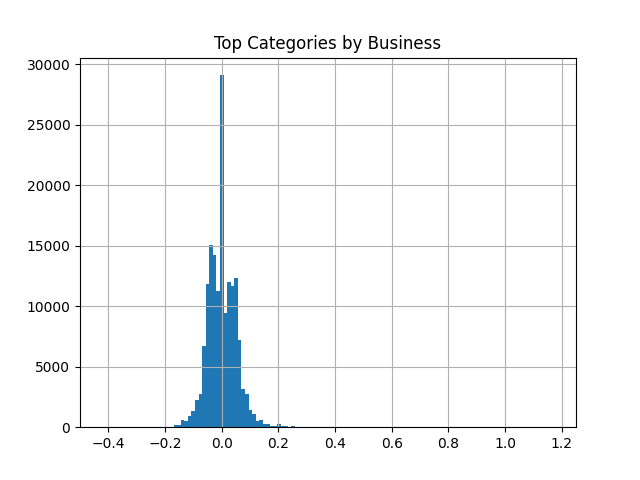

In [38]:
business_skew.toPandas().hist(column = 'Skew', bins = 100)
plt.title('Top Categories by Business')
plt.xlim(-0.5, 1.25)
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [49]:
user = spark.read.json('s3://sta9760f2021-yelp-datasets/yelp_academic_dataset_user.json')
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [50]:
user_review = user.join(review, on = "user_id", how = 'outer')
user_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- user_id: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable =

In [53]:
user_review1 = user_review.withColumn('difference', (user_review['average_stars'] - 
                                                              user_review['stars'] ) / user_review['stars'])
user_review1 = user_review1.select(['average_stars', 'stars', 'difference'])
user_review1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+----------+
|average_stars|stars|difference|
+-------------+-----+----------+
|         2.62|  5.0|    -0.476|
|         3.67|  5.0|    -0.266|
|         2.73|  2.0|     0.365|
|         2.73|  5.0|    -0.454|
|         2.73|  2.0|     0.365|
+-------------+-----+----------+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

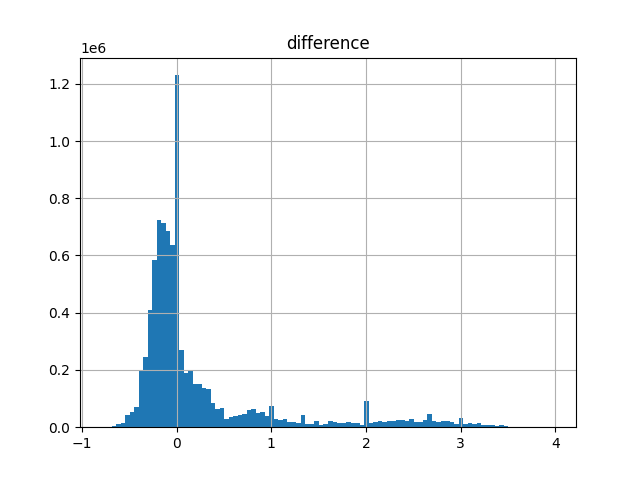

In [54]:
user_review1.toPandas().hist(column = "difference", bins = 100)

%matplot plt

From this figure, we can see that the distribution of the difference is right skewed. This means that the average stars of the users tend to be higher than the stars of the Elite.

## Analysis 2:
How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating?

average stars of an elite user

In [55]:
user.createOrReplaceTempView('user')

user_stats = spark.sql(
'''
SELECT mean(average_stars) AS mean, STDDEV(average_stars) AS standard_dev
FROM user

'''
)
user_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+
|              mean|      standard_dev|
+------------------+------------------+
|3.6538161105699274|1.1538609330757066|
+------------------+------------------+

Average stars of a review

In [56]:
review.createOrReplaceTempView('review')

review_stats = spark.sql(
'''
SELECT mean(stars) AS mean, STDDEV(stars) AS standard_dev
FROM review

'''
)
review_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----------------+
|             mean|     standard_dev|
+-----------------+-----------------+
|3.730958705690979|1.456808728407596|
+-----------------+-----------------+

Average stars of a business

In [57]:
business.createOrReplaceTempView('business')

business_stats = spark.sql(
'''
SELECT mean(stars) AS mean, STDDEV(stars) AS standard_dev
FROM business

'''
)
business_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----------------+
|              mean|     standard_dev|
+------------------+-----------------+
|3.6569542609832797|0.943604488456221|
+------------------+-----------------+

We can see that the average ratings and the standard deviation of an "elite" user is about the same as the actual business rating.

In [58]:
businessUserReview = user_review.join(business, on = 'business_id')
businessUserReview.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- cool: long (nullable =

In [59]:
businessUserReview.select(['friends', 'state', 'categories']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+
|             friends|state|          categories|
+--------------------+-----+--------------------+
|ZdKmQ_xpAU90iqior...|   WA|American (Traditi...|
|ZdKmQ_xpAU90iqior...|   WA|Mediterranean, Mi...|
|ZdKmQ_xpAU90iqior...|   OR|Restaurants, Pizz...|
|ZdKmQ_xpAU90iqior...|   OR|  Pizza, Restaurants|
|ZdKmQ_xpAU90iqior...|   WA|Restaurants, Sush...|
|ZdKmQ_xpAU90iqior...|   WA|Bars, Restaurants...|
|maAxvpjUeHqjV_FJp...|   OR|Nightlife, Restau...|
|tcCJzwrzYSrcQqNoJ...|   FL|Food, Desserts, B...|
|tcCJzwrzYSrcQqNoJ...|   FL|Bars, Nightlife, ...|
|tcCJzwrzYSrcQqNoJ...|   FL|Comfort Food, Wra...|
|tcCJzwrzYSrcQqNoJ...|   FL|Bars, Indian, Res...|
|tcCJzwrzYSrcQqNoJ...|   FL|Mexican, New Mexi...|
|tcCJzwrzYSrcQqNoJ...|   FL|Used Car Dealers,...|
|                None|   GA|Sports Bars, Nigh...|
|                None|   GA|Transportation, A...|
|                None|   GA|Transportation, A...|
|                None|   FL|Golf, Golf Lesson...|


In [60]:
analysis_3 = businessUserReview.select(businessUserReview.friends,
                businessUserReview.state,
                explode(split(businessUserReview.categories, ', ')))
analysis_3.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-----------+
|             friends|state|        col|
+--------------------+-----+-----------+
|ZdKmQ_xpAU90iqior...|   OR|Restaurants|
|ZdKmQ_xpAU90iqior...|   OR|      Pizza|
|ZdKmQ_xpAU90iqior...|   OR|  Nightlife|
|ZdKmQ_xpAU90iqior...|   OR|    Italian|
|ZdKmQ_xpAU90iqior...|   OR|      Pizza|
+--------------------+-----+-----------+
only showing top 5 rows

In [64]:
analysis_3.createOrReplaceTempView('analysis_3')

friendbyStates = spark.sql(
'''
SELECT COUNT(friends), state 
FROM analysis_3
GROUP BY state
ORDER BY count(friends) DESC
LIMIT 9
'''
)
friendbyStates.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+
|count(friends)|state|
+--------------+-----+
|      10689941|   MA|
|       8051285|   TX|
|       7851639|   OR|
|       5975594|   FL|
|       5967913|   GA|
|       2818998|   BC|
|       2203404|   OH|
|        736644|   CO|
|        589754|   WA|
+--------------+-----+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

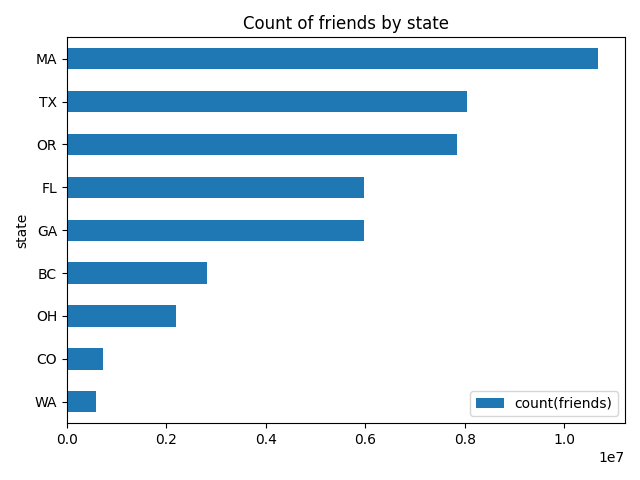

In [65]:
stateFriends = friendbyStates.toPandas()
stateFriends.sort_values('count(friends)', ascending = True).plot.barh(y = "count(friends)", x = 'state',
                                                                     title = 'Count of friends by state',
                                                                      legend = True)
plt.tight_layout()
%matplot plt

As we can see, the highest number of friends by state is in MA, TX, OR and FL